In [84]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



#helper functions

def dot(l1, l2):
    res = 0
    for x, y  in zip(l1,l2):
        res+=x*y
    return res

def c2r(m, c=0):
    res = [None]*len(m)
    for i in range(len(m)):
        res[i] = m[i][c]
    return res

def r2c(m, r=0):
    c = [None]*len(m[r])
    for i, e in enumerate(m[r]):
        c[i] = [e]
    return c

def transpose(m):
    res = [[None]*len(m)]*len(m[0])
    for i in range(len(m)):
        for j in range(len(m[0])):
            res[j][i] = m[i][j]
    return res
    
def matmul(m1, m2):
    assert len(m1[0]) == len(m2)
    
    res = [[None]*len(m2[0])]*len(m1)
    for i in range(len(m1)):
        for j in range(len(m2[0])):
            res[i][j] =  dot(m1[i],c2r(m2, j))
    
    return res

m1 = m2 = [[2]*10]*10
# row vector
v1 = v2 = [[2]*10]


[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [58]:
def norm(x):
    return np.sqrt(np.sum(x**2))

# stationary multi-armed bandit
class BanditEnv:
    
    
    def __init__(self, n_bandits, prob_dist=None):
        if prob_dist is None:
            prob_dist = np.random.rand(n_bandits)
            self.prob_dist = prob_dist/np.sum(prob_dist)
        else:
            self.prob_dist=prob_dist
        assert np.isclose(np.sum(self.prob_dist), 1.0), np.sum(prob_dist)
        
        self.n_bandits = n_bandits
        self.num_actions = n_bandits
    def step(self, a):
        bandit = np.random.choice(np.arange(self.n_bandits), p=self.prob_dist)
        return None, float(bandit==a), None, None

    

# non-stationary multi-armed bandit
class BanditEnvNonstationary:
      
    def __init__(self, n_bandits, walk_mu=0, walk_std=0.01, max_std=3.0):
        
        self.walk_mu = walk_mu
        self.walk_std = walk_std
        
        self.reward_mu = np.random.rand(n_bandits)
        self.reward_std = np.random.rand(n_bandits)*3
              
        self.n_bandits = n_bandits
        self.num_actions = n_bandits
        
    def step(self, a):
        
        r = np.random.normal(self.reward_mu[a], self.reward_std[a])
        
        # random walk reward dist
        
        self.reward_mu += np.random.normal(0, self.walk_std, size=self.n_bandits)
        
        return None, r, None, None


class RandomMDP:
    
    def __init__(self, num_states, num_actions):
        self.num_actions = num_actions
        self.num_states = num_states
       
        ttable = np.random.rand(num_states*num_states*num_actions).reshape((num_states, num_actions, num_states))
        row_sum = np.sum(ttable, axis=2)[:, :, None]
        # normalize table
        self.ttable = ttable/row_sum
        
        # random transitions rewards
        self.rewards = np.random.rand(num_states*num_states).reshape((num_states, num_states))
        self.s_current = 0
        
    def step(self, a):
        assert a < self.num_actions
        
        s_next = np.random.choice(np.arange(self.num_states), p=self.ttable[self.s_current, a])
        r = self.rewards[self.s_current,  s_next]
        self.s_current = s_next
        return s_next, r, False, {}
        
    def reset(self):
        # random initial state
        self.s_current = np.random.randint(self.num_states)
        return self.s_current
    


# Q Learning Multi-armed Bandit

Text(0, 0.5, 'Running mean reward')

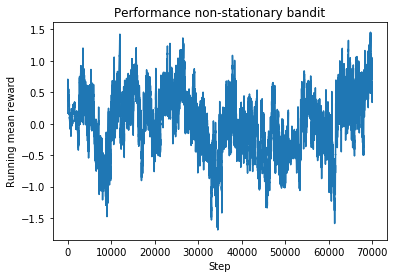

In [92]:
# Q learning
from collections import deque

NUM_ACTIONS = 2
NUM_STATES = 1
env = BanditEnvNonstationary(NUM_ACTIONS)
#env = BanditEnv(NUM_ACTIONS)

q_table = np.zeros((NUM_STATES, NUM_ACTIONS), np.float32)-1

rewards = []
rewards_buff = deque(maxlen=100)
epsilon = .1
gamma = .99
lr = 1e-2
NUM_STEPS = 70000
ACTIONS = np.arange(NUM_ACTIONS)
o = 0
for i in range(NUM_STEPS):
    
    if np.random.rand() < epsilon:
        # random action
        a = np.random.choice(ACTIONS)
        _,r,_,_ = env.step(a)
    else:
        a = np.argmax(q_table[o])
        _,r,_,_  = env.step(a)
    
    # Q update
    qt1 = q_table[o,a]
    qt2 = q_table[o, np.argmax(q_table[o])]
    q_table[o, a] = qt1 + lr*(r + qt2 - qt1)
    
    
    
    rewards_buff.append(r)
    rewards.append(np.mean(rewards_buff))

plt.title('Performance non-stationary bandit')
plt.plot(rewards)
plt.xlabel('Step')
plt.ylabel('Running mean reward')


# Policy Iteration

In [80]:
NUM_STATES = 30
NUM_ACTIONS = 4


class DeterministicPolicy:
    
    def __init__(self, num_states, num_actions):
        self.state_actions = np.random.randint(num_actions, size=num_states)
    def __call__(self, s):
        return self.state_actions[s]
    
class Policy:
    
    def __init__(self, num_states, num_actions):
        # uniform at beginning
        self.act_dist = np.ones((num_states, num_actions))*1./num_actions
        self.num_states = num_states
        self.num_actions = num_actions
    
    def __call__(self, state):
        return np.random.choice(np.arange(self.num_actions), p=self.act_dist[state])
    
    def prob(self, state, action):
        return self.act_dist[state, action]
    
class Value:
    def __init__(self, num_states):
        self.vtable = np.zeros(num_states)
    
    def __call__(self, s):
        return self.vtable[s]
        

    
def policy_evaluation(policy, value_func, states, 
                      ttable, reward_table, theta=.01,gamma=.99):
    """
        Current assumption is that the reward for a transition is deterministic, but
        transitions based on s,a are not.
        TODO make it part of value function itself
    """
    print('Policy Evaluation...')
    max_iterations = 1000
    for i in range(max_iterations):
        delta = 0
        for s in states:
            v = value_func(s)
            v_new = 0
            a = policy(s)
            for s_ in states:
                v_new += ttable[s, a, s_]*(reward_table[s,s_]+gamma*value_func(s_))
            value_func.vtable[s] = v_new
            
            delta = max(delta, abs(v-v_new))
        if delta < theta:
            break
    
    return value_func
            
def policy_improvement(policy, value_func, actions, states, 
                       reward_table, ttable, gamma=.99):
    print('Policy improvement...')
    policy_stable = True
    for s in states:
        old_action = policy(s)
        action_values = np.zeros(len(actions))
        for s_ in states:
            for a in actions:
                action_values[a] += ttable[s, a, s_]*(reward_table[s,s_] + gamma*value_func(s_))
        policy.state_actions[s] = np.argmax(action_values)
        policy_stable = policy.state_actions[s] == old_action
    return policy_stable

    


In [81]:
# testing
env = RandomMDP(100, 4)
STATES = np.arange(env.num_states)
ACTIONS = np.arange(env.num_actions)

policy = DeterministicPolicy(env.num_states, env.num_actions)
value_func = Value(env.num_states)


theta = 0.0001
for i in range(1000):
    
    # 1. policy evaluation
    value_func = policy_evaluation(policy, value_func, STATES,env.ttable, 
                                   env.rewards, theta=theta)
    # 2. policy improvement
    policy_stable = policy_improvement(policy, value_func, ACTIONS, STATES, env.rewards, env.ttable)
    
    if policy_stable:
        break
if not policy_stable:
    print('Failed')
else:
    print('Finished')
    

Policy Evaluation...
Policy improvement...
Policy Evaluation...
Policy improvement...
Finished


In [84]:
random_policy = lambda s: np.random.randint(env.num_actions)

def run_policy(policy, env, num_epochs=200):
    
    epoch_rewards = np.zeros(num_epochs)
    for e in range(num_epochs):
        s = env.reset()
        for i in range(200):
            s, r, d, _ = env.step(policy(s))
            epoch_rewards[e]+=r
    
    return np.sum(epoch_rewards)

random_acc = run_policy(random_policy, env)
opt_acc = run_policy(policy, env)

random_acc, opt_acc

(683.9576080331981, 2509.4728178473697)

# Eligibility Traces TD($\lambda$)

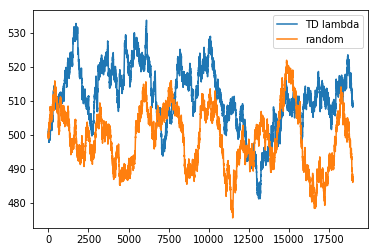

In [65]:
import numpy as np

# backward view
class DiscreteTDLambda:
    
    def __init__(self,lr, ttable, rtable, states, lam=.95, gamma=.99, epsilon=.5, edecay=10000):
        self._states = states
        self._lam = lam
        self._gamma = gamma
        
        self._states = np.arange(ttable.shape[0])        
        self._actions = np.arange(ttable.shape[1])
        self._num_actions = ttable.shape[1]
        self._eligibilities = np.zeros_like(self._states, dtype=np.float32)
        self._value = np.zeros_like(self._states, dtype=np.float32)
        self._lr = 1e-3
        self._ttable = ttable
        self._rtable = rtable
        self._epsilon = epsilon
        self._depsilon = epsilon/edecay
        
    def __call__(self, s):
        action_values = np.zeros(self._num_actions)
        
        # take random action randomly
        if np.random.rand()<self._epsilon:
            return np.random.randint(self._num_actions)
        
        self._epsilon -= self._depsilon
        
        for a in self._actions:
            for s_ in self._states:
                action_values[a] += self._ttable[s,a,s_]*(self._rtable[s,s_]+self._gamma*self._value[s_])
        return np.argmax(action_values)
    
    def update(self, s, r, s_next, d=False):
        # current td error
        td_error = r + self._gamma*self._value[s_next] - self._value[s]
        # update eligibilities
        self._eligibilities*=self._lam*self._gamma
        self._eligibilities[s] += 1.0
        
        # update all state values based on eligibilities
        self._value += self._eligibilities*td_error*self._lr
        
np.random.seed()
env = RandomMDP(20, 2)
STATES = np.arange(env.num_states)
ACTIONS = np.arange(env.num_actions)
ttable = env.ttable
rtable = env.rewards
lr = 1e-4

def run_policy(policy, env, steps=2000):
    
    step_rewards = np.zeros(steps)
    np.random.seed(222)
    s = env.reset()
    for i in range(steps):
        a = policy(s)
        s_, r, d, _ = env.step(a)
        step_rewards[i] = r
        if hasattr(policy, 'update'):
            policy.update(s, r, s_, d)
        s = s_
    
    return step_rewards

def rm(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N])

algo = DiscreteTDLambda(lr, ttable, rtable, states=STATES, gamma=.99, lam=0.95, epsilon=0.2, edecay=5000)
td_lam_res = run_policy(algo, env, 20000)
algo = lambda s: np.random.choice(ACTIONS)
random_pol_res = run_policy(algo, env,20000)


plt.plot(rm(td_lam_res, 1000), label='TD lambda')
plt.plot(rm(random_pol_res, 1000), label='random')
plt.legend()

# Policy Gradient

In [63]:
from collections import deque

class VanillaPolicyGradient:
    
    def __init__(self, num_states, num_actions):
        
        self._num_states = num_states
        self._num_actions = num_actions
        self._state_actions = np.ones(num_states, num_actions, dtype=np.float32)/num_actions
        self._steps = 0
        self._rm = 0.
        self._experience = deque(maxlen=100)
        self._occurences = np.zeros(self._num_states)
        self._values = np.zeros(self._num_states)
    def update(self, s, r, s_, d):
        self._rm += self._steps*self._rm/(self._steps+1) + r/(self.steps_+1)
        self._experience.append((s,r,s_,d))
        rm = 0
        for s,r,s_,d in self._experience:
            rm+=r
        rm/=len(self._experience)
        
        
        
        
    def __call__(self, s):
        self._occurences[s]+=1
        return np.random.choice(np.arange(self._num_states) ,p=self._state_actions[s])
        
        
        
        